# OR 568 - Rogers Rangers
## NYC Rolling Sales Dataset

James Baker

Arturo Davila-Andino

Gridihar Kaushik Ramachandran (GK)

Andrew So

## Developer Notes

IF YOU ARE USING GOOGLE COLABORATORY TO RUN THIS NOTEBOOK, EXPECT PACKAGE IMPORTS TO TAKE ROUGHLY 20 MINUTES - THE PACKAGES NEED TO BE INSTALLED AGAIN WHEN YOU INSTANTIATE THE EXECUTION.

*James B*: For tables, I generally build them in excel and then convert them into Markdown tables at these two links:
* https://tableconvert.com/
* https://www.tablesgenerator.com/markdown_tables

# Initial Setup / Package Imports

In [27]:
# ipak function: install and load multiple R packages.
# check to see if packages are installed. Install them if they are not, then load them into the R session.
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

# usage
packages <- c(
    "ggplot2", 
    "plyr", 
    "mlbench", 
    "e1071", 
    "dplyr", 
    "caret", #  Contains functions to streamline the model training process for complex regression and classification problems
    "pls", # For Partial Least Squares 
    "lars", # For Penalized Models 
    "elasticnet", # For Penalized Models
    "AppliedPredictiveModeling",
    "tidyr",
    "magrittr",
    "stringr",
    "readr",
    "nortest",
    "epiDisplay",
    "corrplot",
    "RColorBrewer", 
    "bestNormalize",
    "randomForest",
    "earth", # For MARS
    "plotmo", # For MARS
    "plotrix", # For MARS
    "TeachingDemos", # For MARS
    "tictoc" # To Time Functions
)
ipak(packages)

ggplot2                      plyr                   mlbench 
                     TRUE                      TRUE                      TRUE 
                    e1071                     dplyr                     caret 
                     TRUE                      TRUE                      TRUE 
                      pls                      lars                elasticnet 
                     TRUE                      TRUE                      TRUE 
AppliedPredictiveModeling                     tidyr                  magrittr 
                     TRUE                      TRUE                      TRUE 
                  stringr                     readr                   nortest 
                     TRUE                      TRUE                      TRUE 
               epiDisplay                  corrplot              RColorBrewer 
                     TRUE                      TRUE                      TRUE 
            bestNormalize              randomForest                     earth 
                     TRUE                      TRUE                      TRUE 
                   plotmo                   plotrix             TeachingDemos 
                     TRUE                      TRUE                      TRUE 
                   tictoc 
                     TRUE

## Dataset Import
Dataset found at: https://www.kaggle.com/new-york-city/nyc-property-sales#


We use a a try-catch block in an attempt to find the NYC Rolling Sales data locally; if it doesn't exist, then read it from the hardcoded Google Drive link.

**Note** We used a variety of both manual and automated methods to massage the data before it hits the R pipeline:

* We used a web-facing API called [Geocod.io](https://www.geocod.io/) to add associated latitude/longitudal data for potential use in the model.

* In addition, we used a PowerShell Script `Process-Address.ps1` in an attempt to strip house numbers from the address in an attempt to categorize records by street name (e.g., properties on Broadway, 5th Avenue, 1st Street, etc.)

**These changes resulted in our using a new dataset called `nyc-rolling-sales-latlong-streets.csv`, which the project will attempt to source locally (if it exists) or via an open endpoint on the Team's Google Drive.**

In [28]:
# The filepath on Google Drive.
drive.fileID <- "1E8NdpOww8IKdN1Kw0NcDPQxycU__hsVu" 
drive.filePath <- sprintf("https://drive.google.com/uc?id=%s",drive.fileID)
file.name <- "nyc-rolling-sales-latlong-streets.csv"

# This is a try-catch block in an attempt to find the NYC Rolling Sales data
# locally; if it doesn't exist, then read it from the hardcoded Google Drive link.
nyc.data <- tryCatch(
    # Try
    {
      message(sprintf("Attempting to read `%s` locally...",file.name))
      read.csv(file.name)
    },
    # Catch
    error = function(cond) {
      message(sprintf("Will use Google Drive Version instead at %s...", drive.filePath))
      return( read.csv(drive.filePath) )
    },
    # Finally
    finally = function(cond) {
      return(message("Unknown error occured!"))
    }
)

cat("Number of Rows: ",nrow(nyc.data), "\nNumber of Cols: ", ncol(nyc.data),"\nShowing first 2 rows...")
head(nyc.data, 2)

Attempting to read `nyc-rolling-sales-latlong-streets.csv` locally...



Number of Rows:  84548 
Number of Cols:  25 
Showing first 2 rows...

,NUM,BOROUGH,NEIGHBORHOOD,BUILDING.CLASS.CATEGORY,TAX.CLASS.AT.PRESENT,BLOCK,LOT,EASE.MENT,BUILDING.CLASS.AT.PRESENT,ADDRESS,...,RESIDENTIAL.UNITS,COMMERCIAL.UNITS,TOTAL.UNITS,LAND.SQUARE.FEET,GROSS.SQUARE.FEET,YEAR.BUILT,TAX.CLASS.AT.TIME.OF.SALE,BUILDING.CLASS.AT.TIME.OF.SALE,SALE.PRICE,SALE.DATE
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<lgl>,<chr>,<chr>,...,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,NA,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,7/19/2017 0:00
2,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,NA,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,12/14/2016 0:00


## Data Dictionary

https://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf

|    <br>         	|    <br>Field                                          	|    <br>Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        	|
|-----------------	|-------------------------------------------------------	|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
|    <br>1        	|    <br>ADDRESS                                        	|    <br>The street   address of the property as listed on the Sales File. Coop sales include the   apartment number in the address field.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  	|
|    <br>2        	|    <br>APARTMENT NUMBER                               	|    <br>The apartment   number of the property (if applicable)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             	|
|    <br>3        	|    <br>BLOCK                                          	|    <br>The   block number (up to 5 digits)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                	|
|    <br>4        	|    <br>BOROUGH                                        	|    <br>A   digit code for the borough the property is located in.<br>   In order, these are:<br>   (1) Manhattan,<br>   (2) Bronx,<br>   (3) Brooklyn,<br>   (4) Queens, and<br>   (5) Staten Island.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     	|
|    <br>5/6      	|    <br>BUILDING CLASS (AT PRESENT/ TIME   OF SALE)    	|    <br>The   Building Classification is used to describe a property’s constructive use.   The first position of the Building Class is a letter that is used to describe   a general class of properties (for example “A” signifies one-family homes,   “O” signifies office buildings. “R” signifies condominiums). The second   position, a number, adds more specific information about the property’s use   or construction style (using our previous examples “A0” is a Cape Cod style   one family home, “O4” is a tower type office building and “R5” is a   commercial condominium unit). The term ‘Building Class’ as used by the   Department of Finance is interchangeable with the term Building Code as used   by the Department of Buildings.<br>   <br> <br>   <br>Refer   to code here:<br>   https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html                                                                                                                                    	|
|    <br>7        	|    <br>BUILDING CLASS CATEGORY                        	|    <br>Refer   to code here:<br>   https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              	|
|    <br>8        	|    <br>COMMERCIAL UNITS                               	|    <br>The number   of commercial units at the listed property.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           	|
|    <br>9        	|    <br>EASE-MENT                                      	|    <br>An   easement is a right, such as a right of way, which allows an entity to make   limited use of another’s real property. For example: MTA railroad tracks that   run across a portion of another property.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       	|
|    <br>10       	|    <br>GROSS SQUARE FEET                              	|    <br>The total   area of all the floors of a building as measured from the exterior surfaces   of the outside walls of the building, including the land area and space   within any building or structure on the property.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              	|
|    <br>11       	|    <br>LAND SQUARE FEET                               	|    <br>The land   area of the property listed in square feet.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             	|
|    <br>12       	|    <br>LOT                                            	|    <br>The   lot number (up to 4 digits)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  	|
|    <br>13       	|    <br>NEIGHBORHOOD                                   	|    <br>Department   of Finance assessors determine the neighborhood name in the course of valuing   properties. The common name of the neighborhood is generally the same as the   name Finance designates. However, there may be slight differences in   neighborhood boundary lines and some sub-neighborhoods may not be included                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      	|
|    <br>14       	|    <br>RESIDENTIAL UNITS                              	|    <br>The   number of houses/apartments intended for use as a place of residence at the   address.<br>   (https://www.lawinsider.com/dictionary/residential-unit)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        	|
|    <br>15       	|    <br>SALE DATE                                      	|    <br>Date the   property sold.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          	|
|    <br>16       	|    <br>SALE PRICE                                     	|    <br>Price paid   for the property.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     	|
|    <br>17/18    	|    <br>TAX CLASS (AT PRESENT/TIME OF   SALE)          	|    <br>Property   in NYC is divided into 4 classes:<br>   Class 1: Most residential property of up to three units<br>   (family homes and small stores or offices with one or two apartments   attached),<br>   and most condominiums that are not more than three stories.<br>   <br>   Class 2: All other property that is not in Class 1 and is primarily   residential<br>   (rentals, cooperatives and condominiums). Class 2 includes:<br>   • Sub-Class 2a (4 - 6 unit rental building);<br>   • Sub-Class 2b (7 - 10 unit rental building);<br>   • Sub-Class 2c (2 - 10 unit cooperative or condominium); and<br>   • Class 2 (11 units or more).<br>   <br>   Class 3: Most utility property.<br>   <br>   Class 4: All commercial and industrial properties, such as office, retail,<br>   factory buildings and all other properties not included in tax classes 1, 2   or 3.<br>   <br>   SOURCE:   https://www1.nyc.gov/site/finance/taxes/definitions-of-property-assessment-terms.page    	|

# Data Processing

## Initial Exploration

First, we examine the head of the data to get an idea of the structure.

In [29]:
# First, we examine the head of the data to get an idea of the structure.
head(nyc.data,2)

# Make all columns lowercase for consistency's sake
colnames(nyc.data) %<>% str_replace_all("\\s", "_") %>% tolower()

,NUM,BOROUGH,NEIGHBORHOOD,BUILDING.CLASS.CATEGORY,TAX.CLASS.AT.PRESENT,BLOCK,LOT,EASE.MENT,BUILDING.CLASS.AT.PRESENT,ADDRESS,...,RESIDENTIAL.UNITS,COMMERCIAL.UNITS,TOTAL.UNITS,LAND.SQUARE.FEET,GROSS.SQUARE.FEET,YEAR.BUILT,TAX.CLASS.AT.TIME.OF.SALE,BUILDING.CLASS.AT.TIME.OF.SALE,SALE.PRICE,SALE.DATE
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<lgl>,<chr>,<chr>,...,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,NA,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,7/19/2017 0:00
2,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,NA,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,12/14/2016 0:00


To further supplement information gathering, we observe how many predictors there are.

In [30]:
# Helper function to pretty print column names for a dataframe
prettyPrintCols <- function(data.frame) {
     print(colnames(data.frame) %<>% str_replace_all("\\s", "_") %>% tolower())
}

In [31]:
# To further supplement information gathering, we observe how many predictors there are.
sprintf("There are %s cols in nyc.data:", ncol(nyc.data))
prettyPrintCols(nyc.data)

[1] "There are 25 cols in nyc.data:"

 [1] "num"                            "borough"                       
 [3] "neighborhood"                   "building.class.category"       
 [5] "tax.class.at.present"           "block"                         
 [7] "lot"                            "ease.ment"                     
 [9] "building.class.at.present"      "address"                       
[11] "street"                         "latitude"                      
[13] "longitude"                      "apartment.number"              
[15] "zip.code"                       "residential.units"             
[17] "commercial.units"               "total.units"                   
[19] "land.square.feet"               "gross.square.feet"             
[21] "year.built"                     "tax.class.at.time.of.sale"     
[23] "building.class.at.time.of.sale" "sale.price"                    
[25] "sale.date"                     


Then, we observe the current structure:

In [32]:
str(nyc.data)

'data.frame':	84548 obs. of  25 variables:
 $ num                           : int  4 5 6 7 8 9 10 11 12 13 ...
 $ borough                       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ neighborhood                  : chr  "ALPHABET CITY" "ALPHABET CITY" "ALPHABET CITY" "ALPHABET CITY" ...
 $ building.class.category       : chr  "07 RENTALS - WALKUP APARTMENTS             " "07 RENTALS - WALKUP APARTMENTS             " "07 RENTALS - WALKUP APARTMENTS             " "07 RENTALS - WALKUP APARTMENTS             " ...
 $ tax.class.at.present          : chr  "2A" "2" "2" "2B" ...
 $ block                         : int  392 399 399 402 404 405 406 407 379 387 ...
 $ lot                           : int  6 26 39 21 55 16 32 18 34 153 ...
 $ ease.ment                     : logi  NA NA NA NA NA NA ...
 $ building.class.at.present     : chr  "C2" "C7" "C7" "C4" ...
 $ address                       : chr  "153 AVENUE B" "234 EAST 4TH   STREET" "197 EAST 3RD   STREET" "154 EAST 7TH STREET" ...
 $ street    

Based on manual observation and what we see in the data here, we observe the following:

* `ease.ment` is 100% null.
* `land.square.feet`, `gross.square.feet`, and `sale.price` are chars when they should be numeric vectors.

So, we will clean the data in the next section.

## Data Cleaning/Transformations in R

### Deep Copy

To begin, we will no longer use `nyc.data` as the dataset for processing in R; we will use a copy to work over and retain the original.

In [33]:
# Begin with creating a deep copy of the nyc.data Dataframe for use onwards.

df <- nyc.data

#TODO: Be sure to split Y from the data BEFORE we boxcox/preprocess.
# df <- subset(nyc.data, select = -c(sale.price))
# df.y <- nyc.data$sale.price

# Maintain an internal switch to use the STREET and LATLONG predictors.
useStreet <- TRUE
useLatLongs <- FALSE

### Nulling unused predictors

`ease.ment`, `apartment.number`, `sale.date` will not be used in the model because they either 

* Do not fit the purpose of the model, or
* Do not have data that can contribute to the model.

This will also NULL out any other predictors that will not be used in the model.

In [34]:
# ### Nulling unused predictors
# `ease.ment`, `apartment.number`, `sale.date` will not be used in the model because they either 
# * Do not fit the purpose of the model, or
# * Do not have data that can contribute to the model.
# This will also NULL out any other predictors" that will not be used in the model.

df$ease.ment <- NULL
df$apartment.number <- NULL
df$sale.date <- NULL

# This is a control function to allow usage of the STREET and
# LATLONG predictors within the data set.
if (!useStreet) {
    print("UseStreet is DISABLED.")
    df$street <- NULL
}

if (!useLatLongs) {
    print("UseLATLONGS is DISABLED.")
    df$latitude <- NULL
    df$longitude <- NULL
}
prettyPrintCols(df)

[1] "UseLATLONGS is DISABLED."
 [1] "num"                            "borough"                       
 [3] "neighborhood"                   "building.class.category"       
 [5] "tax.class.at.present"           "block"                         
 [7] "lot"                            "building.class.at.present"     
 [9] "address"                        "street"                        
[11] "zip.code"                       "residential.units"             
[13] "commercial.units"               "total.units"                   
[15] "land.square.feet"               "gross.square.feet"             
[17] "year.built"                     "tax.class.at.time.of.sale"     
[19] "building.class.at.time.of.sale" "sale.price"                    


### Recasting predictors

#### Numerics
`sale.price`, `land.square.feet`, and `gross.square.feet` were identified to have been malformed, so they will be re-cast as numeric vectors.

##### Price and Square Footage

In [35]:
# #### Numerics
# `sale.price`, `land.square.feet`, and `gross.square.feet` were identified to have been malformed, 
# so they will be re-cast as numeric vectors.

##### Price and Square Footage
df$sale.price <- as.numeric(as.character(df$sale.price))
df$land.square.feet <- as.numeric(as.character(df$land.square.feet))
df$gross.square.feet <- as.numeric(as.character(df$gross.square.feet))

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


#### Factors
The following predictors can be factorized (made into categories):

In [36]:
# #### Factors
# The following predictors can be factorized (made into categories):
df$borough <- as.factor(df$borough)
df$neighborhood <- as.factor(df$neighborhood)
df$building.class.category <- as.factor(df$building.class.category)

# PRESENT CATEGORIES
df$tax.class.at.present <- as.factor(df$tax.class.at.present)
df$building.class.at.present <- as.factor(df$building.class.at.present)

# TIME OF SALE
df$tax.class.at.time.of.sale <- as.factor(df$tax.class.at.time.of.sale)
df$building.class.at.time.of.sale <- as.factor(df$building.class.at.time.of.sale) 

# ZIP CODE
df$zip.code <- as.factor(df$zip.code)

# Logic to use Street; if so, then remove the Address since it has no 
# utility here.
if (useStreet) {
    df$street <- as.factor(df$street)
    df$address <- NULL
}

#### Factorizing building age

There are a few options that we can do here with respect to the building's age:
We can:
1. Convert to `age` by subtracting from 2017
2. Convert to intervals
3. Convert to factor and leave as is

**The team chooses option 3.**

In [37]:
#doing option 3
df$year.built <- as.factor(df$year.built)
# df$sale.price = as.numeric(df$sale.price) # ??? This seems redundant

#### Data Filtering

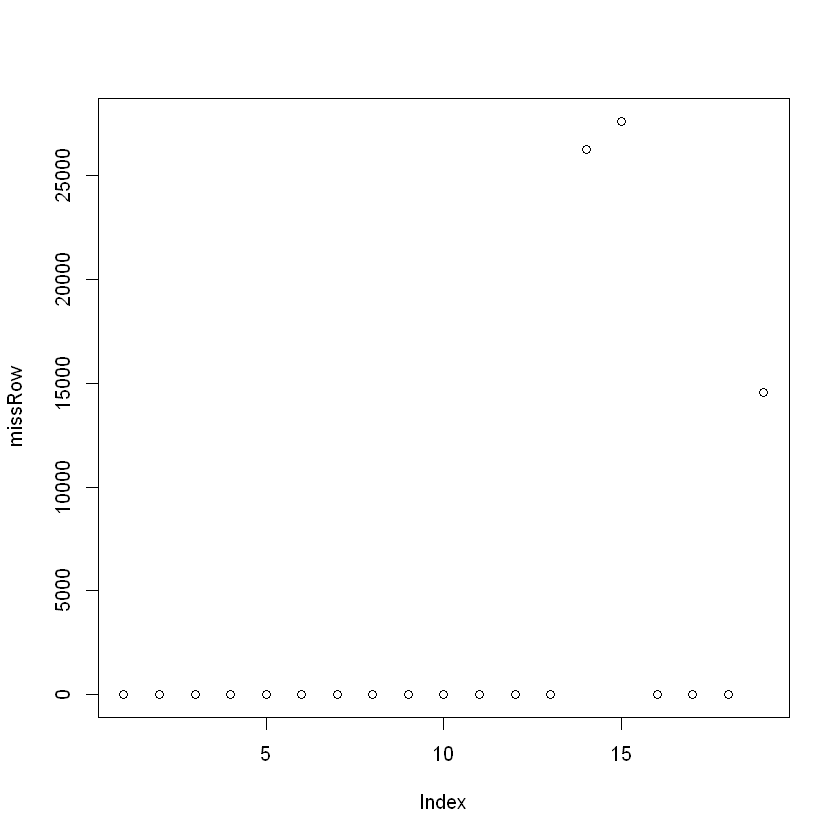

In [38]:
missRow <- colSums(is.na(df))
plot(missRow)

##### Before Dropping Nulls

We apply a filter to the dataset to do the following:
* Remove observations with incomplete results (lack of dimensions + sale price)

##### Applying filters
The following filters are applied to the dataset:
* Eliminate incomplete observations by dropping records with NULL values in square footage and sale price.
* Reining in gross and land square feet to properties > 100 square feet.
 * This is done to remove records that are either too dirty or have no significant contribution with respect to real estate
* Using only sale prices greater than \\$100,000
 * This is done because price per square foot *realistically* would be (extremely optimistically) $1000/sq. ft in NYC; a minimum

In [39]:
# drop NA's that were created during the conversion from the "-" value
df <- df %>% drop_na(c(gross.square.feet,land.square.feet, sale.price))

# removing datapoints whose sqftage is less than 100
# removing datapoints whose sale price is <100k. Since median price @nyc is around 1.8k
df <- df %>% filter(land.square.feet>100) 
df <- df %>% filter(gross.square.feet >100)
df <- df %>% filter(sale.price>100000)

In [40]:
freq_dist_sale_price <- df %>% group_by(sale.price) %>% summarize(Freq = n())
freq_dist_land_square_feet <- df %>% group_by(land.square.feet) %>% summarize(Freq = n())
freq_dist_gross_square_feet <- df %>% group_by(gross.square.feet) %>% summarize(Freq = n())

# TODO: Add additional filters here? As it is, data is heavily skewed towards commercial properties

new_freq_dist_sale_price <- df %>% group_by(sale.price) %>% summarize(Freq = n())
new_freq_dist_land_square_feet <- df %>% group_by(land.square.feet) %>% summarize(Freq = n())
new_freq_dist_gross_square_feet <- df %>% group_by(gross.square.feet) %>% summarize(Freq = n())

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



## Descriptive Stats for Price and Square Footage

In [42]:
# Descriptive Stats
print("For `sale.price`...")
max(df$sale.price)
class(df$sale.price)
max(df$sale.price)
min(df$sale.price)

cat("\n")
print("For `gross.square.feet`...")
max(df$gross.square.feet)
min(df$gross.square.feet)

cat("\n")
print("For `land.square.feet`...")
max(df$land.square.feet)
min(df$land.square.feet)

[1] "For `sale.price`..."


[1] 2.21e+09

[1] "numeric"

[1] 2.21e+09

[1] 100700


[1] "For `gross.square.feet`..."


[1] 3750565

[1] 120


[1] "For `land.square.feet`..."


[1] 4228300

[1] 200

## Adjusting the data for skewness

To get an idea of the skewness of the data, we will produce a histogram.

We choose `gross.square.feet` arbitrarily.

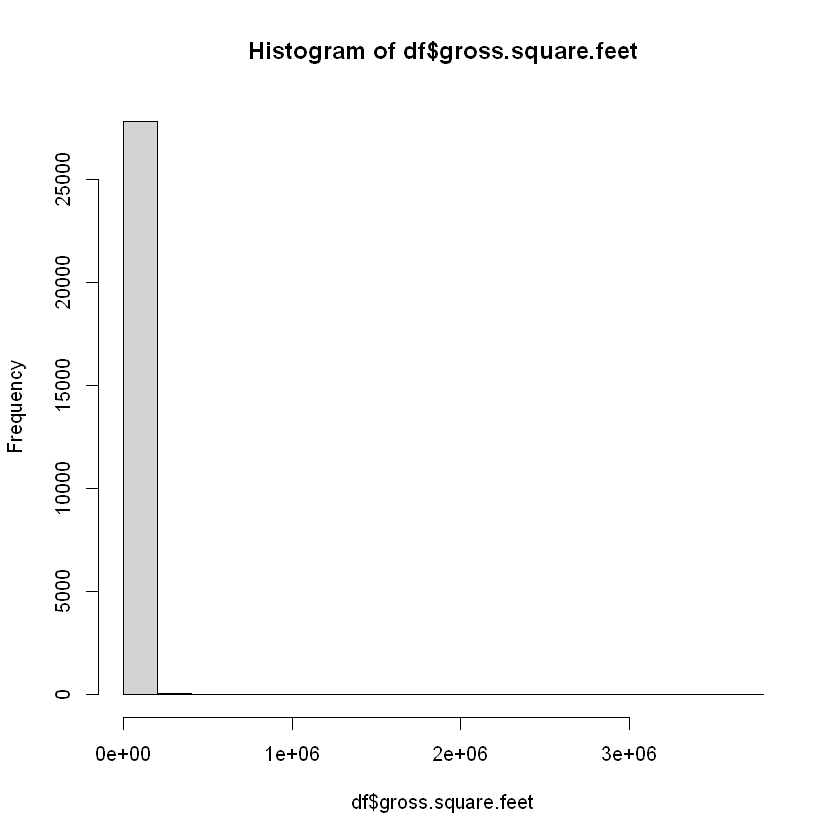

In [43]:
# hist(df$sale.price)
hist(df$gross.square.feet)

Based on the histogram above for gross square feet, we observed that the data was heavily skewed and can benefit from a Box Cox + Center/Scaling transformation for improved model performance.

BEFORE we do that though, we will separate `sale.price` from the dataframe to prevent the same transformation from applying to the response.

In [44]:
# Based on the histogram above for gross square feet, we observed that the data was heavily skewed and can benefit 
# from a Box Cox + Center/Scaling transformation for improved model performance.
# BEFORE we do that though, we will separate `sale.price` from the dataframe to 
# prevent the same transformation from applying to the response.
df.y <- as.data.frame(df$sale.price)
colnames(df.y) <- c("sale.price")

df <- subset(df, select = -c(sale.price))

# Validate that sale.price has been removed from the structure of the main data frame.
prettyPrintCols(df)

 [1] "num"                            "borough"                       
 [3] "neighborhood"                   "building.class.category"       
 [5] "tax.class.at.present"           "block"                         
 [7] "lot"                            "building.class.at.present"     
 [9] "street"                         "zip.code"                      
[11] "residential.units"              "commercial.units"              
[13] "total.units"                    "land.square.feet"              
[15] "gross.square.feet"              "year.built"                    
[17] "tax.class.at.time.of.sale"      "building.class.at.time.of.sale"


### BoxCox / Centering / Scaling

We use the `preProcess()` method to prep a boxcox /centering / scaling routine against the dataset.

In [45]:
# Preload a preprocessing routine
df.preProc <- preProcess(
    df,
    method = c("BoxCox", "center", "scale")
)

In [46]:
## Apply the transformations
df.trans <- predict(df.preProc, df)

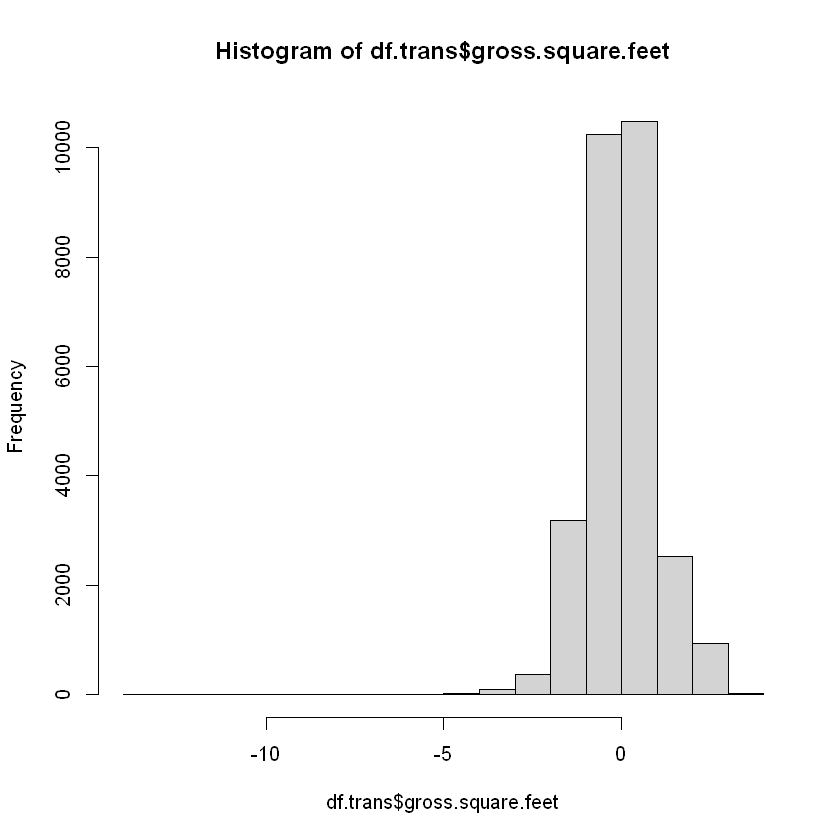

In [47]:
hist(df.trans$gross.square.feet)

## Multicollinearity Test

,residential.units,commercial.units,total.units,land.square.feet,gross.square.feet
residential.units,1.00000000,0.01141646,0.8159458,0.45834076,0.72133987
commercial.units,0.01141646,1.00000000,0.5873982,0.05409284,0.06542233
total.units,0.81594584,0.58739820,1.0000000,0.40223680,0.62164517
land.square.feet,0.45834076,0.05409284,0.4022368,1.00000000,0.66646086
gross.square.feet,0.72133987,0.06542233,0.6216452,0.66646086,1.00000000


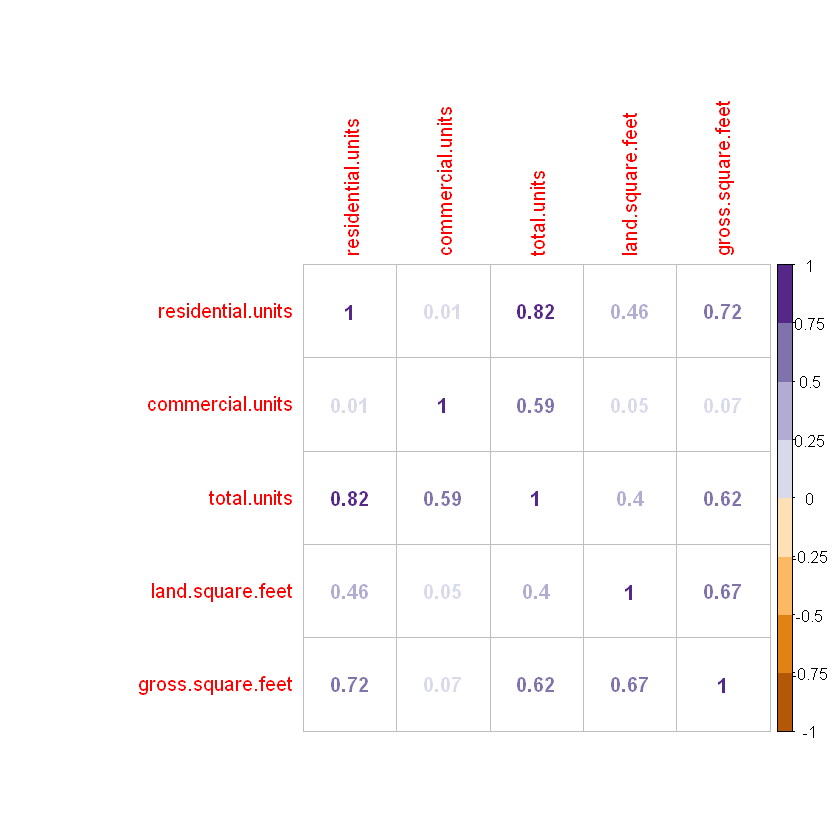

In [48]:
# check multicollinearity
numericpredictors <- c('residential.units','commercial.units','total.units','land.square.feet','gross.square.feet')
df_numpreds <- subset(df, select= numericpredictors)
corr <- cor(df_numpreds)
corr
corrplot(corr,method= "number",col=brewer.pal(n=8, name="PuOr"))

## Data Culling

In [49]:
#remove total units as a predictor since it is highly correlated to # of residential units and commercial units

# one hot encoding the categorical variables
# borough 
# neighborhood
# building.class.category 
# tax.class.at.present 
# building.class.at.present
# zip.code
# year.built
# tax.class.at.time.of.sale
# building.class.at.time.of.sale

dmy <- dummyVars(" ~ borough +
neighborhood +
building.class.category +
tax.class.at.present +
building.class.at.present +
zip.code +
year.built +
tax.class.at.time.of.sale +
building.class.at.time.of.sale", data = df)
trsf <- data.frame(predict(dmy, newdata = df))
dim(trsf)

df_for_modeling <- cbind(trsf, df_numpreds)
dim(df_for_modeling)

[1] 27910   998

[1] 27910  1003

# Modeling

## Data Partitioning


In [50]:
# Set seed
# create a list of random number ranging from 1 to number of rows from actual data 
# and 70% of the data into training data
set.seed(824452)
df.shuffled <- sort(sample(nrow(df.trans), nrow(df.trans)*.7))

# Create both training and test data sets by using the random ordering created 
# in the preceding executed line 
df.train <- as.data.frame(df.trans[df.shuffled,])
df.test <- as.data.frame(df.trans[-df.shuffled,])

df.y.train <- as.data.frame(df.y[df.shuffled,])
df.y.test <- as.data.frame(df.y[-df.shuffled,])

# Rename the columns to `sale.price` since that gets removed in the midst of indexing. 
colnames(df.y.train) <- c("sale.price")
colnames(df.y.test) <- c("sale.price")

## Linear Regression - James B Section

In [51]:
df.glm.train <- df.train
df.glm.test <- df.test

df.y.glm.train <- df.y.train
df.y.glm.test <- df.y.test

### Manual Execution

In [ ]:
# LINEAR REGRESSION
# Run separate partitions of the training/test datasets
# Time the execution
tic()
glmFit.manual <- glm(df.y.glm.train$sale.price ~ ., data=df.glm.train)
glmFit.manual
toc()

In [ ]:
tic()
glmFitPred.manual <- predict(glmFit.manual, df.glm.test)
glmValue.manual <- data.frame(obs = df.y.glm.test, pred = glmFitPred.manual[,,1])
toc()

In [ ]:
table(df.glm.test$neighborhood)
table(df.glm.train$neighborhood)

In [ ]:
cat("GLM - Manual")
defaultSummary(glmValue.manual)
cat("\n")

In [ ]:
df.glm.train$street <- NULL
df.glm.test$street <- NULL

### `caret` with 10-fold cross validation

In [ ]:
# df.glm.train <- df.train
# df.glm.test <- df.test

# df.y.glm.train <- df.y.train
# df.y.glm.test <- df.y.test

# create control
# glm.ctrl <- trainControl(method = "cv", number = 10)
tic()
glmFit.CV <- train(
    x = df.glm.train, # select features/predictors
    y = df.y.glm.train$sale.price, # select outcome
    method = "glm"
#     trControl = glm.ctrl
)
toc()

glmFit.CV

In [ ]:
tic()
glmFitPred.CV <- predict(glmFit.CV, df.test)
glmValue.CV <- data.frame(obs = df.y.test, pred = glmFitPred.CV[,,1])
toc()

In [ ]:
cat("GLM - CV")
defaultSummary(glmValue.CV)
cat("\n")

## Ordinary Least squares and Robust Linear regression

In [ ]:
str(df.train)
dmy <- dummyVars(" ~ borough +
neighborhood +
building.class.category +
tax.class.at.present +
building.class.at.present +
zip.code +
street+
year.built +
tax.class.at.time.of.sale +
building.class.at.time.of.sale", data = df)
trsf <- data.frame(predict(dmy, newdata = df))
dim(trsf)

df_for_modeling <- cbind(trsf, df_numpreds)
dim(df_for_modeling)

In [ ]:
tic()

In [ ]:
df.lm.train <- df.train
df.lm.y.train <- df.y.train
df.lm.y.train_trf <- log(df.lm.y.train)

df.lm.test <- df.test
df.lm.y.test <- df.y.test

df_linearmodel <- cbind(df.lm.train,df.lm.y.train_trf)
str(df_linearmodel)

#linearmodel = lm(df.lm.train$sale.price ~ .,df.lm.train)
#lm_prediction <- predict(linearmodel,df.lm.test)

'data.frame':	19537 obs. of  19 variables:
 $ num                           : num  -2.56 -2.52 -2.11 -2.11 -2.1 ...
 $ borough                       : Factor w/ 5 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ neighborhood                  : Factor w/ 254 levels "AIRPORT LA GUARDIA",..: 2 2 2 2 2 2 40 40 40 40 ...
 $ building.class.category       : Factor w/ 47 levels "01 ONE FAMILY DWELLINGS                    ",..: 7 7 15 15 15 21 1 2 3 7 ...
 $ tax.class.at.present          : Factor w/ 11 levels " ","1","1A","1B",..: 7 7 7 7 7 11 2 2 2 8 ...
 $ block                         : num  -1.87 -1.86 -1.87 -1.87 -1.87 ...
 $ lot                           : num  -1.519 0.432 -0.504 -1.876 -1.68 ...
 $ building.class.at.present     : Factor w/ 167 levels " ","A0","A1",..: 17 17 141 142 143 83 10 140 15 19 ...
 $ street                        : Factor w/ 8077 levels "****** 95TH STREET ",..: 1890 3296 3703 1890 1890 1891 7707 7696 7707 73 ...
 $ zip.code                      : Factor w/

In [ ]:
toc()

tic()

0.08 sec elapsed


In [ ]:
#Robust linear regression
robust_linearmodel = rlm(df_linearmodel$sale.price ~ .,df_linearmodel)
rlm_prediction = predict(robust_linearmodel,df.lm.test)

ERROR: ignored

In [ ]:
summary(df.lm.train)#$sale.price

In [ ]:
toc()

## Partial Least Squares

### Create control for PLS Model

This is the `trainControl` method used for Partial Least Squares; this model will use 10-folds Cross Validation for model resampling.


In [ ]:
# create control
pls.ctrl <- trainControl(method = "cv", number = 10)

# Get train/test data sets.
df.pls.train <- df.train
df.pls.test <- df.test

df.y.pls.train <- df.y.train
df.y.pls.test <- df.y.test

In [ ]:
str(df.pls.train)

### Manual PLS

We set the number of components to measure against as 10, then we will use the 
`plsr()` function to invoke the partial least squares regression.

In [ ]:
tic() # Start Timer

In [ ]:
### Manual PLS
# We set the number of components to measure against as 10, then we will use the 
# `plsr()` function to invoke the partial least squares regression.
numComponents <- 10
plsFit.manual = plsr(df.y.pls.train$sale.price ~., data = df.pls.train, ncomp = numComponents)

In [ ]:
summary(plsFit.manual)

In [ ]:
# try on the test data, and then evaluate the results.
plsPred.manual = predict(plsFit.manual, df.pls.test, ncomp = numComponents)
plsValue.manual = data.frame(obs = df.y.pls.test$sale.price, pred = plsPred.manual[,,1])

In [ ]:
cat("Partial Least Squares (Manual)")
defaultSummary(plsValue.manual)
cat("\n")

In [ ]:
toc() # Stop Timer

Based on the results of the manual PLS model, we can see that $R^{2}\,\approx\,0.17$, which indicates that the model was ill-suited to predict or observe a linear relationship between all of the predictors.

### `TrainControl`-based PLS with 10-folds cross validation

To verify/validate the results seen in the manual PLS model, we will use a `TrainControl` to automate a 10-fold cross validation of a PLS model. 

In [ ]:
tic() # Start Timer

In [ ]:
# #### `TrainControl`-based PLS with 10-folds cross validation
# To verify/validate the results seen in the manual PLS model, we will use a `TrainControl` 
# to automate a 10-fold cross validation of a PLS model. 

# Partial Least Squares - Automated
plsFit.CV <- train(
    x = df.pls.train, # select features/predictors
    y = df.y.pls.train$sale.price, # select outcome
    method = "pls",
    tuneGrid = expand.grid(ncomp = numComponents),
    trControl = pls.ctrl
)

In [ ]:
summary(plsFit.CV)

In [ ]:
plsPred.CV <- predict(plsFit.CV, df.pls.test)

In [ ]:
plsTest.CV <- data.frame(obs = df.y.pls.test$sale.price, pred = predict(plsFit.CV, df.pls.test))
defaultSummary(plsTest.CV)

In [ ]:
toc() # Stop Timer

Based on the results seen above, the results are virtually indistinguishable from the manual PLS model.

## Tree Based Regression

We will use the same partitioned data from the Partial Least Squares Section.

In [ ]:
df.tree.train <- df.train
df.y.tree.train <- df.y.train

In [ ]:
tic() # Start timer

In [ ]:
# Setting the seed for our Regression Tree Model
set.seed(4000)

treebasedfit <- train(
  x= df.tree.train, 
  y= df.y.tree.train$sale.price,
  method = "rpart2",
  tuneLength = 20,
  trControl = trainControl(method = "cv")
)

treebasedfit
plot(treebasedfit)

In [ ]:
toc() # Stop Timer

## Elastic Net

In [ ]:
tic()

In [ ]:
# GK's Code to convert to binary predictors
numericpredictors <- c('residential.units','commercial.units','total.units','land.square.feet','gross.square.feet')
df_numpreds <- subset(df, select= numericpredictors)

dmy <- dummyVars(" ~ borough +
neighborhood +
building.class.category +
tax.class.at.present +
building.class.at.present +
zip.code +
year.built +
tax.class.at.time.of.sale +
building.class.at.time.of.sale", data = df)
trsf <- data.frame(predict(dmy, newdata = df))
dim(trsf)

df_for_modeling <- cbind(trsf, df_numpreds)
dim(df_for_modeling)

# Partition Data
nearZeroVar(df_for_modeling)
df.enet.train <- df_for_modeling[df.shuffled,-nearZeroVar(df_for_modeling)]
df.enet.test <- df_for_modeling[-df.shuffled,-nearZeroVar(df_for_modeling)]

df.y.enet.train <- df.y[df.shuffled,]
df.y.enet.test <- df.y[-df.shuffled,]

# Train Control
enet.ctrl <- trainControl("LGOCV")

# Tune Grid
k=10


# Train Model
enetFit.MC <- train(x = df.enet.train, # select features/predictors
                   y = df.y.enet.train, # select outcome
                   method = "enet",
                   tuneGrid = expand.grid(.fraction = .2*(1:k)/k, .lambda=.001*(1:k)/k),
                   trControl = enet.ctrl,
                   preProc = c("center", "scale"))

# Summary
summary(enetFit.MC)
enetFit.MC$bestTune
plot(enetFit.MC)

#Preditction
enetPred.MC <- predict(enetFit.MC, df.enet.test)

enetTest.MC <- data.frame(obs = df.y.enet.test, pred = predict(enetFit.MC, df.enet.test))
defaultSummary(enetTest.MC)


In [ ]:
toc()

## MARS

In [ ]:
tic()

In [ ]:
# Partition Data
df.mars.train <- df.train
df.mars.test <- df.test

df.y.mars.train <- df.y[df.shuffled,]
df.y.mars.test <- df.y[-df.shuffled,]

# Train Control
mars.ctrl <- trainControl("LGOCV")

# Tune Grid
marsGrid = expand.grid(.degree=1:3, .nprune=2:15)

# Train Model Packages must be loaded prior 
marsFit.MC <- train(x = df.mars.test, # select features/predictors
                   y = df.y.mars.test, # select outcome
                   method = "earth",
                   tuneGrid = marsGrid,
                   trControl = mars.ctrl)

warnings()

# Summary
summary(marsFit.MC)
marsFit.MC$bestTune
plot(marsFit.MC)

#Prediction
marsPred.MC <- predict(marsFit.MC, df.mars.test)

marsTest.MC <- data.frame(obs = df.y.mars.test, pred = predict(marsFit.MC, df.mars.test))
defaultSummary(marsTest.MC)

In [ ]:
toc()

# RAW CODE - GK

In [ ]:
# head(nycdata)

# colnames(nycdata) %<>% str_replace_all("\\s", "_") %>% tolower()
# colnames(nycdata)

# str(nycdata)

# df <- nycdata
# df$sale.price <- as.numeric(as.character(df$sale.price))
# df$land.square.feet <- as.numeric(as.character(df$land.square.feet))
# df$gross.square.feet <- as.numeric(as.character(df$gross.square.feet))

# df$ease.ment = NULL
# df$apartment.number = NULL
# df$sale.date = NULL

# df$borough = as.factor(df$borough)
# df$neighborhood = as.factor(df$neighborhood)
# df$building.class.category = as.factor(df$building.class.category)
# df$tax.class.at.present = as.factor(df$tax.class.at.present )

# #block and lot

# df$building.class.at.present = as.factor(df$building.class.at.present)

# #address needs to be feature engineered
# # avenue, broadway etc.

# df$zip.code = as.factor(df$zip.code)

# #total units is a calculated field. can be ignored

# #convert sqftage to numeric
# df$land.square.feet = as.numeric(df$land.square.feet)
# df$gross.square.feet = as.numeric(df$gross.square.feet)

# #need to feature engineer year built- 
# # option 1- convert to 'age' by subtracting from 2017
# # option 2- convert to intervals
# # option 3- convert to factor and leave as is

# #doing option 3
# df$year.built <- as.factor(df$year.built)

# df$tax.class.at.time.of.sale = as.factor(df$tax.class.at.time.of.sale)
# df$building.class.at.time.of.sale = as.factor(df$building.class.at.time.of.sale)

# df$sale.price = as.numeric(df$sale.price)

# # removed NA and keep only distinct records
# df <- df %>% distinct() %>% drop_na(c(gross.square.feet,land.square.feet, sale.price))

# #drop NA's that were created during the conversion from the "-" value
# df <- df %>% drop_na(c(gross.square.feet,land.square.feet, sale.price))

# freq_dist_sale_price <- df %>% group_by(sale.price) %>% summarize(Freq = n())
# freq_dist_land_square_feet <- df %>% group_by(land.square.feet) %>% summarize(Freq = n())
# freq_dist_gross_square_feet <- df %>% group_by(gross.square.feet) %>% summarize(Freq = n())

# freq_dist_sale_price
# freq_dist_land_square_feet
# freq_dist_gross_square_feet

# # removing datapoints whose sqftage is less than 100
# # removing datapoints whose sale price is <100k. Since median price @nyc is around 1.8k

# df <-df%>% filter(land.square.feet>100) 
# df<- df %>% filter(gross.square.feet >100)
# df<- df %>% filter(sale.price>100000)

# new_freq_dist_sale_price <- df %>% group_by(sale.price) %>% summarize(Freq = n())
# new_freq_dist_land_square_feet <- df %>% group_by(land.square.feet) %>% summarize(Freq = n())
# new_freq_dist_gross_square_feet <- df %>% group_by(gross.square.feet) %>% summarize(Freq = n())

# max(nycdata$sale.price)
# class(nycdata$sale.price)
# max(df$sale.price)
# min(df$sale.price)

# max(df$gross.square.feet)
# min(df$gross.square.feet)

# max(df$land.square.feet)
# min(df$land.square.feet)

# hist(df$sale.price)
# hist(df$gross.square.feet)

# # check multicollinearity
# install.packages("corrplot")
# library(corrplot)
# library(RColorBrewer)
# numericpredictors <- c('residential.units','commercial.units','total.units','land.square.feet','gross.square.feet','sale.price')
# df_numpreds <- subset(df, select= numericpredictors)
# corr <- cor(df_numpreds)
# corr
# corrplot(corr,method= "number",col=brewer.pal(n=8, name="PuOr"))

# #remove total units as a predictor since it is highly correlated to # of residential units and commercial units

# # one hot encoding the categorical variables
# # borough 
# # neighborhood
# # building.class.category 
# # tax.class.at.present 
# # building.class.at.present
# # zip.code
# # year.built
# # tax.class.at.time.of.sale
# # building.class.at.time.of.sale

# dmy <- dummyVars(" ~ borough +
# neighborhood +
# building.class.category +
# tax.class.at.present +
# building.class.at.present +
# zip.code +
# year.built +
# tax.class.at.time.of.sale +
# building.class.at.time.of.sale", data = df)
# trsf <- data.frame(predict(dmy, newdata = df))
# dim(trsf)

# df_for_modeling <- cbind(trsf, df_numpreds)
# dim(df_for_modeling)

# #split data into train, validation and test
# inTraining <- createDataPartition(df_for_modeling$sale.price, p = .70, list = FALSE)
# trainset <- df_for_modeling[ inTraining,]
# testandvalidation  <- df_for_modeling[-inTraining,]

# testid <- createDataPartition(testandvalidation$sale.price, p = .50, list = FALSE)
# testset <- testandvalidation[testid,]
# validationset <- testandvalidation[-testid,]

# dim(trainset)
# dim(validationset)
# dim(testset)

# # training various models

# #Simple Linear Regression

In [ ]:
plot(nycdata[2],main = colnames(nycdata[2]))
plot(nycdata[3],main = colnames(nycdata[3]))
plot(nycdata[4],main = colnames(nycdata[4]))
plot(nycdata[5],main = colnames(nycdata[5]))
plot(nycdata[6],main = colnames(nycdata[6]))
plot(nycdata[7],main = colnames(nycdata[7]))
plot(nycdata[8],main = colnames(nycdata[8]))
#plot(nyc.data[9],main = colnames(nyc.data[9])) Address not done
# library(hexbin)
#hexbinplot(latitude~longitude, data=nycdata)
#plot(nyc.data[10],main = colnames(nyc.data[10]))
#plot(nyc.data[11],main = colnames(nyc.data[11]))
#plot(nyc.data[12],main = colnames(nyc.data[12])) Apt number not done
plot(nyc.data[13],main = colnames(nycdata[13]))
histogram(nycdata$residential.units)
histogram(nycdata$commercial.units)
histogram(nycdata$total.units)
histogram(nycdata$land.square.feet)
histogram(nycdata$gross.square.feet)
histogram(nycdata$year.built)
plot(nyc.data[20],main = colnames(nycdata[20]))
plot(nyc.data[21],main = colnames(nycdata[21]))
histogram(nycdata$sale.price)

In [ ]:
nyc.data2 <- nyc.data
nyc.data2 <- nyc.data2[which(nyc.data$LATITUDE <= 41),]
nyc.data2 <- nyc.data2[which(nyc.data2$LATITUDE >= 40),]
nyc.data2 <- nyc.data2[which(nyc.data2$LONGITUDE <= -73.6),]
hexbinplot(LATITUDE~LONGITUDE, data=nyc.data2)
nyc.data2 <- nyc.data2[which(nyc.data2$LAND.SQUARE.FEET <= 1000000),]
nyc.data2 <- nyc.data2[which(nyc.data2$LAND.SQUARE.FEET >= 100),]
nyc.data2 <- nyc.data2[which(nyc.data2$GROSS.SQUARE.FEET >= 100),]
nyc.data2 <- nyc.data2[which(nyc.data2$SALE.PRICE >= 100000),]
nyc.data2 <- nyc.data2[which(nyc.data2$YEAR.BUILT >= 1500),]